# **Experiments on fashion-mnist dataset**

In [1]:
import os
import time 
import psutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")
process = psutil.Process(os.getpid())

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
train = pd.read_csv('./fashion-mnist_train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('./fashion-mnist_test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_train, y_train = train.drop('label', axis=1)/255, train.label
x_train.shape, y_train.shape

((60000, 784), (60000,))

In [6]:
x_test, y_test = test.drop('label', axis=1)/255, test.label
x_test.shape, y_test.shape

((10000, 784), (10000,))

In [7]:
# Creating OneHot Vector
classes = np.unique(y_train)
y_train_onehot = np.eye(len(classes))[y_train]
y_test_onehot = np.eye(len(classes))[y_test]
y_train_onehot.shape, y_test_onehot.shape

((60000, 10), (10000, 10))

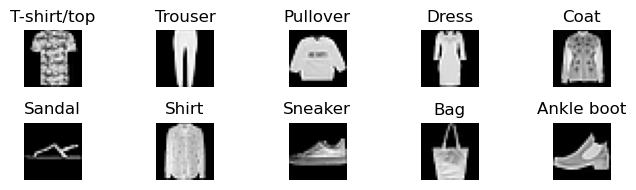

In [12]:
# Plotting the dataset images
Y = np.unique(y_train)
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
          'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Getting one image from each class
imgs = np.array([x_train.loc[np.where(y_train == n)[0][0], :] for n in Y])
plt.figure(figsize=(7, 2))
for i in range(len(Y)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i, :].reshape(28, 28), cmap='gray')
    # Set the title as the corresponding label
    plt.title(labels[i])
    # Remove axis ticks
    plt.axis('off')
# Adjust layout
plt.tight_layout()
plt.show()

# Training the MLP on the whole dataset


In [8]:
# Taking a Sample for hyperparameter tuning
_, x_train_sample, _, y_train_sample = train_test_split(x_train,
                                                        y_train,
                                                        test_size=0.3,
                                                        stratify=y_train,
                                                        shuffle=True,
                                                        random_state=42)
y_train_sample_onehot = np.eye(len(classes))[y_train_sample]
x_train_sample.shape, y_train_sample_onehot.shape

((18000, 784), (18000, 10))

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [100,120,150,180],
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_grid.fit(x_train_sample, y_train_sample_onehot)

# Variables to track the time and memory used by the model
e = time.time()
memAF = process.memory_info().rss

In [10]:
# Printing time, memory taken by the model
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
mlp_grid.best_params_

Time taken in training: 9324.26 sec
Memory taken in training: 19072.0 MB


{'activation': 'relu',
 'hidden_layer_sizes': (256, 256, 128, 128, 128, 64, 64, 64),
 'max_iter': 150}

In [17]:
# Training the MLP model on the whole dataset on the optimized parameters 
s = time.time()
memBS = process.memory_info().rss

mlp_wd = MLPClassifier(random_state = 42, early_stopping=False, **mlp_grid.best_params_)
mlp_wd.fit(x_train, y_train_onehot)

e = time.time()
memAF = process.memory_info().rss

# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_wd.score(x_test, y_test_onehot)*100:.2f}%")

Time taken in training: 1981.79 sec
Memory taken in training: 28274.9 MB
Accuracy on testing dataset: 90.07%


In [12]:
# Predicting on the test data
y_pred = mlp_wd.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision  Recall  F1 Score  Support
0   0.841851   0.873  0.857143     1000
1   0.986948   0.983  0.984970     1000
2   0.851129   0.829  0.839919     1000
3   0.903960   0.913  0.908458     1000
4   0.842315   0.844  0.843157     1000
5   0.987355   0.937  0.961519     1000
6   0.767051   0.731  0.748592     1000
7   0.927815   0.964  0.945562     1000
8   0.972305   0.983  0.977623     1000
9   0.949355   0.956  0.952666     1000


# Taking random sample of 300 example


In [13]:
# Taking 300 examples for training
_, x_train_300, _, y_train_300 = train_test_split(x_train, y_train, test_size=300, stratify=y_train, random_state=0)
x_train_300.shape, y_train_300.shape

((300, 784), (300,))

In [14]:
# Changing into onehot vector
y_train_300_onehot = np.eye(len(classes))[y_train_300]
y_train_300_onehot.shape

(300, 10)

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [
        (256,256,128,128,64),
        (256,256,128,128,64,64),
        (256,256,128,128,64,64,64)
    ],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [150,180,200,220,240],
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_grid_300 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_grid_300.fit(x_train_300.values, y_train_300_onehot)

# Variables to track the time and memory used by the model
e = time.time()
memAF = process.memory_info().rss

In [13]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_grid_20.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_grid_20.best_params_

Time taken in training: 750.69 sec
Memory taken in training: 280.0 MB
Accuracy on testing dataset: 72.78%


{'activation': 'tanh',
 'hidden_layer_sizes': (256, 256, 128, 128, 64, 64),
 'learning_rate': 'constant',
 'max_iter': 220}

In [17]:
# Predicting on the test data
y_pred = mlp_grid_20.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision  Recall  F1 Score  Support
0   0.787611   0.712  0.747899     1000
1   0.953299   0.939  0.946096     1000
2   0.680124   0.657  0.668362     1000
3   0.768293   0.819  0.792836     1000
4   0.714467   0.563  0.629754     1000
5   0.921123   0.689  0.788330     1000
6   0.575650   0.487  0.527627     1000
7   0.807729   0.836  0.821622     1000
8   0.945493   0.902  0.923234     1000
9   0.860835   0.866  0.863410     1000


# Clustering the images into 300 clusters


In [18]:
# Clustering the x_train images 
n_clusters = 300
kmean = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
distances = kmean.fit_transform(x_train.values)

# distance from images to their centroid and their labels
distances.shape, kmean.labels_.shape

((60000, 300), (60000,))

In [19]:
# Finding the nearest image to each centroid
x_train_clust = []
y_train_clust = []
for n in range(n_clusters):
    images_dist = []
    # Getting the indices of images for centroid n
    image_inds = np.where(kmean.labels_ == n)[0]
    for i in image_inds:
        image = x_train.loc[i, :]
        label = y_train.loc[i]
        dist = distances[i, n]
        images_dist.append((image, label, dist))
    
    # Sorting the images_dist list respect to 'dist'
    images_dist.sort(key=lambda x: x[2])
    #  After sorting the first image is nearest to centroid
    # Therefore, we'll take its label
    y_train_clust.append(images_dist[0][1])
    
    images = [img.values for img, _, _ in images_dist]
    x_train_clust.append(np.array(images))
    
len(x_train_clust), len(y_train_clust)

(300, 300)

## Take single image which is near to the centroid from each cluster


In [20]:
# Taking image which is nearest to the centroid and its label as training example for each cluster
x_train_clust_1 = np.array([x_train_clust[i][0, :] for i in range(n_clusters)])
y_train_clust_1 = np.array(y_train_clust)

# Changing into onehot vector
y_train_clust_1_onehot = np.eye(len(classes))[y_train_clust_1]
x_train_clust_1.shape, y_train_clust_1_onehot.shape

((300, 784), (300, 10))

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,128,128),
                           (256,256,128,128),
                           (256,256,128,128,64,64),
                           (256,256,128,128,64,64,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [150,180,200,220,240]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_clust_1 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_clust_1.fit(x_train_clust_1, y_train_clust_1_onehot)

# Variables to track the time and memory used by the model
e = time.time()
memAF = process.memory_info().rss

In [22]:
# Printing time, memory taken by the model
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
mlp_clust_1.best_params_

Time taken in training: 877.36 sec
Memory taken in training: 18984.0 MB


{'activation': 'tanh',
 'hidden_layer_sizes': (256, 256, 128, 128, 64, 64),
 'learning_rate': 'constant',
 'max_iter': 220}

In [14]:
print(f"Accuracy on testing dataset: {mlp_clust_1.score(x_test.values, y_test_onehot)*100:.2f}%")

Accuracy on testing dataset: 74.34%


In [24]:
# Predicting on the test data
y_pred = mlp_clust_1.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision  Recall  F1 Score  Support
0   0.761853   0.707  0.733402     1000
1   0.974306   0.948  0.960973     1000
2   0.720327   0.528  0.609348     1000
3   0.871429   0.732  0.795652     1000
4   0.680401   0.611  0.643836     1000
5   0.967905   0.573  0.719849     1000
6   0.487521   0.586  0.532243     1000
7   0.778420   0.808  0.792934     1000
8   0.948936   0.892  0.919588     1000
9   0.777869   0.949  0.854955     1000


# Propagate the above situation to the entire cluster for each respective cluster


In [25]:
# Taking whole dataset as training data
x_train_clust_100 = np.vstack(x_train_clust)
# Giving all images label which nearest image to the centroid has for each cluster
y_train_clust_100 = np.hstack([np.array([y_train_clust[i]]*x_train_clust[i].shape[0]) for i in range(n_clusters)])

# Changing into onehot vector
y_train_clust_100_onehot = np.eye(len(classes))[y_train_clust_100]
x_train_clust_100.shape, y_train_clust_100_onehot.shape

((60000, 784), (60000, 10))

In [26]:
# Sample for hyperparameter tuning
_, x_train_sample, _, y_train_sample_onehot = train_test_split(x_train_clust_100,
                                                        y_train_clust_100_onehot,
                                                        test_size=0.3,
                                                        stratify=y_train,
                                                        shuffle=True,
                                                        random_state=42)
x_train_sample.shape, y_train_sample_onehot.shape

((18000, 784), (18000, 10))

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,256,128,128,64),
                           (256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64,32)],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [70,80,90,100,110,150]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 0, early_stopping=False, shuffle=True)
mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_grid.fit(x_train_sample, y_train_sample_onehot)

# Variables to track the time and memory used by the model
e = time.time()
memAF = process.memory_info().rss

In [28]:
# Printing time, memory taken by the model
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
mlp_grid.best_params_

Time taken in training: 15929.27 sec
Memory taken in training: 14228.0 MB


{'activation': 'tanh',
 'hidden_layer_sizes': (256, 256, 256, 128, 128, 128, 64, 64, 64),
 'max_iter': 80}

In [15]:
# Training the model on the whole dataset with the optimal parameters
s = time.time()
memBS = process.memory_info().rss

mlp_clust_100 = MLPClassifier(random_state = 0, early_stopping=False, shuffle=True, **mlp_grid.best_params_)
mlp_clust_100.fit(x_train_clust_100, y_train_clust_100_onehot)

e = time.time()
memAF = process.memory_info().rss

# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_clust_100.score(x_test.values, y_test_onehot)*100:.2f}%")

Time taken in training: 1486.68 sec
Memory taken in training: 10892.0 MB
Accuracy on testing dataset: 75.67%


In [30]:
# Predicting on the test data
y_pred = mlp_clust_100.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision  Recall  F1 Score  Support
0   0.692453   0.734  0.712621     1000
1   0.991489   0.932  0.960825     1000
2   0.627219   0.530  0.574526     1000
3   0.838746   0.749  0.791337     1000
4   0.559109   0.577  0.567913     1000
5   0.962418   0.589  0.730769     1000
6   0.429167   0.515  0.468182     1000
7   0.754011   0.846  0.797361     1000
8   0.927435   0.933  0.930209     1000
9   0.752396   0.942  0.836590     1000


# Propagate the clustering to 25% images near to centroid


In [31]:
# Taking first 25% images form each cluster
clust_prc = 0.25
x_train_clust_20 = np.vstack([clust[:int(clust.shape[0]*clust_prc), :] for clust in x_train_clust])
y_train_clust_20 = np.hstack([np.array([y_train_clust[i]]*int(x_train_clust[i].shape[0]*clust_prc)) for i in range(len(x_train_clust))])

# Converting into onehot vectors
y_train_clust_20_onehot = np.eye(len(classes))[y_train_clust_20]
x_train_clust_20.shape, y_train_clust_20_onehot.shape

((14887, 784), (14887, 10))

In [ ]:
# Variables to track the time and memory used by the model
s = time.time()
memBS = process.memory_info().rss

# Hyper Parameters to tune
param_grid = {
    'hidden_layer_sizes': [(256,256,128,128,64,64),
                           (256,256,128,128,64,64,64),
                           (256,256,128,128,128,64,64,64),
                           (256,256,256,128,128,128,64,64,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'max_iter': [80,90,100,120]
}

# Hyper-Parameter tunning using GridSearchCV
mlp = MLPClassifier(random_state = 42, early_stopping=False)
mlp_clust_20 = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
mlp_clust_20.fit(x_train_clust_20, y_train_clust_20_onehot)

# Variables to track the time and memory used by the modelv
e = time.time()
memAF = process.memory_info().rss

In [16]:
# Printing time, memory taken by the model and accuracy on the test data
print(f"Time taken in training: {round(e-s, 2)} sec")
print(f"Memory taken in training: {round((memAF-memBS)/1024, 2)} MB")
print(f"Accuracy on testing dataset: {mlp_clust_20.score(x_test.values, y_test_onehot)*100:.2f}%")
mlp_clust_20.best_params_

Time taken in training: 5869.01 sec
Memory taken in training: 8464.0 MB
Accuracy on testing dataset: 77.0%


{'activation': 'tanh',
 'hidden_layer_sizes': (256, 256, 128, 128, 64, 64, 64),
 'max_iter': 120}

In [36]:
# Predicting on the test data
y_pred = mlp_clust_20.predict(x_test)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test_onehot, y_pred)
results_df = pd.DataFrame({'Precision': precision,
                           'Recall': recall,
                           'F1 Score': f1_score,
                           'Support': support},
                          index=range(len(precision)))

print("Metrics for each class:")
print(results_df)

Metrics for each class:
   Precision  Recall  F1 Score  Support
0   0.694499   0.707  0.700694     1000
1   0.986402   0.943  0.964213     1000
2   0.608981   0.556  0.581286     1000
3   0.792570   0.768  0.780091     1000
4   0.581609   0.506  0.541176     1000
5   0.916318   0.657  0.765288     1000
6   0.440000   0.528  0.480000     1000
7   0.826964   0.779  0.802266     1000
8   0.940816   0.922  0.931313     1000
9   0.723338   0.936  0.816042     1000
